# **Twitter Sentiment Analysis** 

### Understanding Brand Perception Through Natural Language Processing

## Business Problem and Context

In today's digital marketplace, social media has become the primary channel where customers express their opinions about products and brands. For companies like Apple and Google, understanding public sentiment on Twitter can provide invaluable insights into:

- **Product reception**: How are new product launches being received?
- **Brand health**: What's the overall sentiment toward our brand vs competitors?
- **Crisis detection**: Can we identify emerging negative sentiment before it becomes a PR crisis?
- **Customer service prioritization**: Which complaints need immediate attention?

**The Challenge**: Manually analyzing thousands of tweets daily is impossible. Customer service teams are overwhelmed, and by the time negative sentiment is identified through traditional methods, brand damage may already be done.

**Our Solution**: Build an automated sentiment classification system that can process Twitter data in real-time, categorizing tweets as positive, negative, neutral, or uncertain. This system will help stakeholders:

1. Monitor brand health continuously
2. Identify trending issues early
3. Route negative sentiment to customer service teams
4. Measure campaign effectiveness

**Success Metrics**: We aim to build a model that can accurately classify tweet sentiment with high precision and recall, particularly for negative sentiment (where misclassification is most costly from a business perspective).

## Table of Contents

1. [Business Understanding](#business-problem-and-context)
2. [Data Understanding](#data-understanding)
3. [Data Preparation](#data-preparation)
4. [Exploratory Data Analysis](#exploratory-data-analysis)
5. [Text Preprocessing & Feature Engineering](#text-preprocessing-and-feature-engineering)
6. [Modeling](#modeling)
7. [Model Evaluation & Interpretation](#model-evaluation-and-interpretation)
8. [Conclusions & Recommendations](#conclusions-and-recommendations)

## Data Understanding

Our dataset consists of tweets collected during the South by Southwest (SXSW) conference, where Apple and Google products were prominently discussed. Each tweet has been manually labeled by human judges for sentiment toward specific brands or products.

This is a real-world dataset with all its messiness: typos, slang, emojis, hashtags, and the informal language typical of social media. Understanding this data is our first critical step.


### Importing Libraries

In [8]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Text processing and NLP
import re
import string
from collections import Counter

# NLTK for advanced NLP tasks (required by rubric)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Scikit-learn for machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_recall_fscore_support
)

# For model persistence
import joblib

# Set random seed for reproducibility
np.random.seed(42)

### Loading and Initial Exploration

In [9]:
df = pd.read_csv("../data/judge-1377884607_tweet_product_company.csv",encoding="latin1")
df.head()


# basic information
print("Dataset Shape:", df.shape)
print("\n" + " "*5)
print("Column Names:")
print(" "*3)
for col in df.columns:
    print(f"  - {col}")

print("\n" + " "*60)
print("First Few Rows:")
print(" "*6)
df.head()

Dataset Shape: (9093, 3)

     
Column Names:
   
  - tweet_text
  - emotion_in_tweet_is_directed_at
  - is_there_an_emotion_directed_at_a_brand_or_product

                                                            
First Few Rows:
      


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Rename columns for clarity and ease of use

In [10]:
df.columns = ['tweet', 'product', 'sentiment']

print("Renamed columns:")
df.head()


Renamed columns:


,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Dataset Overview

Structure and completeness of our data.

In [11]:
print("Dataset Information:")
print(" "*6)

df.info()


Dataset Information:
      
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataframe has a total of 9093 entries, with two columns having nulls

In [12]:
print("Missing Values:")

df.isnull().sum()

Missing Values:


tweet           1
product      5802
sentiment       0
dtype: int64

In [13]:
df.duplicated().sum()

np.int64(22)

Their are 22 duplicated entries/rows in our dataset


### Class Imbalance Analysis

In [14]:
df['sentiment'].value_counts(normalize = True) * 100

sentiment
No emotion toward brand or product    59.265369
Positive emotion                      32.750467
Negative emotion                       6.268558
I can't tell                           1.715605
Name: proportion, dtype: float64

The dataset shows class imbalance, with `No emotion toward brand or product` accounting for approximately 59% of all observations. `Positive emotion` stands at 32%, with `Negative emotion` (≈6%) and *I can't tell* (≈2%) are underrepresented, which may bias the model toward the majority class.


## Data Preparation

Data cleaning is crucial for NLP. Poor quality data leads to poor model performance, regardless of model sophistication.


### Handling Missing Values

In [15]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [16]:
# Removing the one row with missing tweet text (can't analyze what doesn't exist)
df = df.dropna(subset=['tweet'])

# For missing products, we'll fill with 'Unknown' rather than dropping
# These tweets still have sentiment and can be valuable for analysis
df['product'] = df['product'].fillna('Unknown')

print(f"Dataset shape after handling missing values: {df.shape}")
print(f"\nRemaining missing values:")
print(df.isnull().sum())

Dataset shape after handling missing values: (9092, 3)

Remaining missing values:
tweet        0
product      0
sentiment    0
dtype: int64


### Removing Duplicates

Duplicate tweets can skew our model by giving certain patterns excessive weight. We'll remove them to ensure each unique opinion is counted once.

In [17]:
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

Dataset shape after removing duplicates: (9070, 3)


### Understanding Sentiment Distribution

In [18]:
# Examine sentiment distribution
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = df['sentiment'].value_counts(normalize=True) * 100

sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage': sentiment_percentages.round(2)
})

print("Sentiment Distribution:")
print(sentiment_summary)

Sentiment Distribution:
                                    Count  Percentage
sentiment                                            
No emotion toward brand or product   5375       59.26
Positive emotion                     2970       32.75
Negative emotion                      569        6.27
I can't tell                          156        1.72


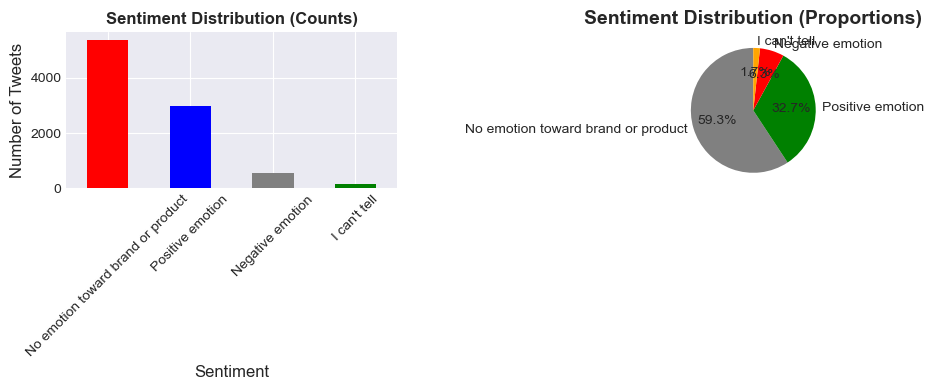

In [19]:
# Visualizing the sentiment distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Count plot
sentiment_counts.plot(kind='bar',ax=ax1,color=['red', 'blue', 'gray', 'green'])
ax1.set_title('Sentiment Distribution (Counts)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Sentiment', fontsize=12)
ax1.set_ylabel('Number of Tweets', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Pie chart
colors = ['gray', 'green', 'red', 'orange']
ax2.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax2.set_title('Sentiment Distribution (Proportions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Critical Business Insight:**

The data reveals a **significant class imbalance**:
- ~59% of tweets have **no emotion** toward products
- ~33% express **positive emotion**
- Only ~6% express **negative emotion**
- ~2% are **uncertain**

This imbalance mirrors reality: most social media mentions are neutral, and people are more likely to express positive opinions than negative ones in public forums like SXSW.

**Modeling Implications:**
1. We cannot rely solely on accuracy as our metric
2. We need to carefully consider precision and recall, especially for negative sentiment
3. The small "I can't tell" category may not be worth modeling separately




### Refining Our Target Variable

We create a simplified 3-class problem by combining `No emotion" and "I can't tell` into a single "Neutral" category. This makes business sense: from a customer service perspective, uncertain sentiment is functionally similar to neutral.

In [20]:
# Creating a simplified sentiment mapping
sentiment_mapping = {
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'Neutral'
}

df['sentiment_clean'] = df['sentiment'].map(sentiment_mapping)

# Verifying the mapping
print("Simplified Sentiment Distribution:")
print(" "*1)
print(df['sentiment_clean'].value_counts())
print("\nPercentages:")
print(df['sentiment_clean'].value_counts(normalize=True).mul(100).round(2))

Simplified Sentiment Distribution:
 
sentiment_clean
Neutral     5531
Positive    2970
Negative     569
Name: count, dtype: int64

Percentages:
sentiment_clean
Neutral     60.98
Positive    32.75
Negative     6.27
Name: proportion, dtype: float64


In [21]:
df.head()

,tweet,product,sentiment,sentiment_clean
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Positive


## Exploratory Data Analysis

Understand patterns in our text data. What makes a tweet positive vs negative? Are there specific words or phrases that signal sentiment?

### Tweet Length Analysis

Does the length of a tweet correlate with its sentiment? This could be a useful feature.

In [ ]:
# adding tweet characteristics; length and word count

df['tweet_length'] = df['tweet'].astype(str).apply(len)
df['word_count'] = df['tweet'].astype(str).apply(lambda x: len(x.split()))

In [ ]:
# new shape
df.head()

In [ ]:
# Analyzing by sentiment
length_by_sentiment = df.groupby('sentiment_clean')[['tweet_length', 'word_count']].agg(['mean', 'median'])
print("Tweet Characteristics by Sentiment:")
print(" "*6)
print(length_by_sentiment.round(2))

In [ ]:
# Visualizing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df.boxplot(column='tweet_length', by='sentiment_clean', ax=axes[0])
axes[0].set_title('Tweet Length Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=11)
axes[0].set_ylabel('Character Count', fontsize=11)
plt.sca(axes[0])
plt.xticks(rotation=0)

df.boxplot(column='word_count', by='sentiment_clean', ax=axes[1])
axes[1].set_title('Word Count Distribution by Sentiment', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=11)
axes[1].set_ylabel('Word Count', fontsize=11)
plt.sca(axes[1])
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

**Observation**: Tweet length and word count are relatively consistent across sentiments, though negative tweets show slightly more variability. This suggests length alone won't be a strong predictor - the specific words matter more than how many there are.


### Product Mention Analysis

Understanding which products are mentioned most frequently and their associated sentiment helps us identify brand-specific patterns.

In [ ]:
df['product'].value_counts()

In [ ]:
# Analyzing product mentions (excluding 'Unknown')
product_sentiment = pd.crosstab(df['product'], df['sentiment_clean'])
top_products = df['product'].value_counts().head(10)

print("Top 10 Most Mentioned Products:")
print(" "*2)
print(top_products)

In [ ]:

# Visualizing sentiment distribution for top products
top_product_names = top_products.index.tolist()
if 'Unknown' in top_product_names:
    top_product_names.remove('Unknown')
    top_product_names = top_product_names[:9]
else:
    top_product_names = top_product_names[:9]

product_sentiment_filtered = product_sentiment.loc[top_product_names]

fig, ax = plt.subplots(figsize=(12, 6))
product_sentiment_filtered.plot(kind='bar', stacked=False, ax=ax, color=['red', 'gray', 'green'])
ax.set_title('Sentiment Distribution Across Top Products', fontsize=14, fontweight='bold')
ax.set_xlabel('Product', fontsize=12)
ax.set_ylabel('Number of Tweets', fontsize=12)
ax.legend(title='Sentiment', title_fontsize=11, fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Business Insight**: The iPad dominates the conversation, followed by Apple and Google products. Most mentions are neutral, but there's a healthy proportion of positive sentiment. Negative sentiment is rare but critical to identify.


## Text Preprocessing and Feature Engineering

We need to transform messy, unstructured text into features our models can learn from. We'll use NLTK (as required by the rubric) to perform sophisticated text preprocessing beyond basic cleaning.

In [ ]:
def clean_tweet(text):
    if pd.isna(text):
        return ""
    
    text = re.sub(r'http\S+|www\S+', '', text)   # URLs
    text = re.sub(r'@\w+', '', text)             # Mentions
    text = re.sub(r'#', '', text)                # Hashtag symbol
    text = re.sub(r'[^a-zA-Z\s]', '', text)      # Special chars
    text = text.lower().strip()                  # Normalize
    
    return text

df['tweet_cleaned'] = df['tweet'].apply(clean_tweet)

df['tweet_cleaned'].head()

### Text Processing with NLTK

Applying lemmatization using NLTK. 

We'll also remove stopwords that don't carry sentiment information.

In [ ]:
# NLTK setup
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))
sentiment_words = {'not', 'no', 'nor', 'but', 'against'}
stop_words -= sentiment_words


def advanced_preprocess(text):
    if not text:
        return ""
    
    tokens = word_tokenize(text)
    
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and len(token) > 2
    ]
    
    return ' '.join(tokens)


df['tweet_processed'] = df['tweet_cleaned'].apply(advanced_preprocess)

df['tweet_processed'].head()

### Remove Empty Tweets

In [ ]:
# Remove empty processed tweets
initial_count = len(df)
df = df[df['tweet_processed'].str.strip() != '']
removed_count = initial_count - len(df)

print(f"Removed {removed_count} empty tweets after preprocessing")
print(f"Final dataset shape: {df.shape}")

### Feature Engineering: N-grams Analysis

Individual words (unigrams) don't always capture meaning. Phrases like "not good" have the opposite meaning of "good." We'll analyze bigrams (2-word phrases) and trigrams (3-word phrases) to understand common sentiment-bearing phrases.

In [ ]:
def get_top_ngrams(corpus, n=2, top_k=15):
    
    ngram_list = []
    
    for text in corpus:
        tokens = text.split()
        ngram_list.extend(list(ngrams(tokens, n)))
    
    ngram_freq = Counter(ngram_list)
    return ngram_freq.most_common(top_k)

# Analyze bigrams for each sentiment
print("\nMost Common Bigrams by Sentiment:")
print(" "*2)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    corpus = df[df['sentiment_clean'] == sentiment]['tweet_processed'].tolist()
    top_bigrams = get_top_ngrams(corpus, n=2, top_k=10)
    
    print(f"\n{sentiment.upper()}:")
    print(" " * 2)
    for bigram, count in top_bigrams:
        print(f"  {' '.join(bigram):30s} : {count}")

**Key Findings from N-grams**:

These bigram patterns reveal important linguistic signals:
- Positive sentiment: phrases like "check out," "love [product]," "come see"
- Negative sentiment: phrases indicating problems or frustration
- Neutral sentiment: informational phrases and product names
This analysis validates that capturing multi-word expressions will improve our models.




### Most Frequent Words by Sentiment

visualizing the most distinctive words for each sentiment category.

In [ ]:
def get_top_words(corpus, top_n=20):
    """
    Get the most frequent words from a corpus.
    """
    all_words = ' '.join(corpus).split()
    word_freq = Counter(all_words)
    return word_freq.most_common(top_n)

# Creating visualizations for each sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sentiments = ['Positive', 'Negative', 'Neutral']
colors = ['steelblue', 'slategray', 'seagreen']

for idx, (sentiment, color) in enumerate(zip(sentiments, colors)):
    corpus = df[df['sentiment_clean'] == sentiment]['tweet_processed'].tolist()
    top_words = get_top_words(corpus, top_n=15)
    
    words, counts = zip(*top_words)
    
    axes[idx].barh(range(len(words)), counts, color=color, alpha=0.7)
    axes[idx].set_yticks(range(len(words)))
    axes[idx].set_yticklabels(words)
    axes[idx].invert_yaxis()
    axes[idx].set_xlabel('Frequency', fontsize=11)
    axes[idx].set_title(f'Top Words - {sentiment} Sentiment', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
**Analysis**: 
- Product names (iPad, Apple, Google, iPhone) dominate across all sentiments
- Positive tweets show action words and enthusiasm ("get," "new," "launch")

We need to use TF-IDF instead of simple word counts to weight words by their importance.


## Wordcloud

visualizing frequent word mentions on positive and negative sentiments using wordcloud

In [ ]:
from wordcloud import WordCloud
def create_wordcloud(sentiment_label, title):
    # Combine all tweets for the specific sentiment
    text = " ".join(tweet for tweet in df[df['sentiment'] == sentiment_label].tweet)
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='black',
        colormap='viridis',
        max_words=100
    ).generate(text)
    
    # Display the plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

# Visualize WordClouds for different sentiments
create_wordcloud('Positive emotion', 'Most Common Words in Positive Tweets')
create_wordcloud('Negative emotion', 'Most Common Words in Negative Tweets')

## Modeling

Building machine learning models to classify tweet sentiment automatically. We'll take an iterative approach, starting simple and progressively refining our models.

### Strategy:
1. **Baseline Model**: Simple Naive Bayes with basic TF-IDF
2. **Improvement 1**: Tune vectorization (include bigrams, adjust parameters)
3. **Improvement 2**: Try more sophisticated models (Logistic Regression, Linear SVM, XGBoost)
4. **Comparison**: Evaluate trade-offs and select best model for deployment